<br>
<br>
<center>
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/F1.svg/320px-F1.svg.png" alt="image.png">
  <h1>IS THE GRID POSITION ENOUGH FOR A PODIUM FINISH IN FORMULA 1?</h1>
</center>

<br>
<br>

## MAIN REQUIREMENTS FROM COURSERA

Sections required in your report:

* Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation and the benefits that your analysis provides to the business or stakeholders of this data.

* Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis.

* Brief summary of data exploration and actions taken for data cleaning and feature engineering.

* Summary of training at least three different classifier models, preferably of different nature in explainability and predictability. For example, you can start with a simple logistic regression as a baseline, adding other models or ensemble models. Preferably, all your models use the same training and test splits, or the same cross-validation method.

* A paragraph explaining which of your classifier models you recommend as a final model that best fits your needs in terms of accuracy and explainability.

* Summary Key Findings and Insights, which walks your reader through the main drivers of your model and insights from your data derived from your classifier model.

* Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model after adding specific data features that may help you achieve a better explanation or a better prediction.

## DESCRIPTION AND TARGET

Main objective is to provide a brief interpretation on following question:


“In Formula 1, on which circuits does starting in the top 3 affect the likelihood of a podium finish? "

Results will be given as a sorted list of circuits along with the probabilities of finishing in the top 3.
 
Two datasets have been used: “results.csv” and “races.csv”. These datasets have been taken from kaggle. 

Columns to be analyzed in these datasets and their descriptions:

<br>

| COLUMN NAME | DATASET      | DESCRIPTION                                                       |
|-------------|--------------|-------------------------------------------------------------------|
| raceId      | results.csv  | Every race in the dataset has a unique number.                    |
| grid        | results.csv  | Starting position of a driver.                                    |
| position    | results.csv  | Finishing position of a driver.                                   |
| raceId      | races.csv    | This column is used in merging two datasets.                      |
| year        | races.csv    | Date of a Formula 1 race in years.                                |
| circuitId   | races.csv    | Every circuit in the Formula 1 calendar has a unique number.      |
| name        | races.csv    | Name of a circuit.                                                


## DATA CLEANING AND DATA EXPLORATION

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import data

In [2]:
df_results = pd.read_csv("results.csv")
df_results.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')

In [3]:
df_races = pd.read_csv("races.csv")
df_races.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')

### Merge and clean the data

In [4]:
# Use only necessary columns for modelling

df_results = df_results[["raceId", "grid", "position"]]
df_races = df_races[["raceId", "year", "circuitId", "name"]]

In [5]:
df = df_results.merge(df_races, on="raceId", how = "inner")
df.head()

,raceId,grid,position,year,circuitId,name
0,18,1,1,2008,1,Australian Grand Prix
1,18,5,2,2008,1,Australian Grand Prix
2,18,7,3,2008,1,Australian Grand Prix
3,18,11,4,2008,1,Australian Grand Prix
4,18,3,5,2008,1,Australian Grand Prix


In [6]:
# New columns that labels starting and finishing in podium
# Starting case: starting in top 3
# Finishing case: finishing in top 3

def top_three(track_position):
    return 'Yes' if track_position in [1, 2, 3] or track_position in ["1","2","3"] else 'No'

df['start'] = df['grid'].apply(top_three)
df['finish'] = df['position'].apply(top_three)
df.head()

,raceId,grid,position,year,circuitId,name,start,finish
0,18,1,1,2008,1,Australian Grand Prix,Yes,Yes
1,18,5,2,2008,1,Australian Grand Prix,No,Yes
2,18,7,3,2008,1,Australian Grand Prix,No,Yes
3,18,11,4,2008,1,Australian Grand Prix,No,No
4,18,3,5,2008,1,Australian Grand Prix,Yes,No


In [7]:
# Drop "position" columns since "start", "grid" and "finish" to be used in modelling

df = df.drop(columns=["position"])

In [8]:
df.head()

,raceId,grid,year,circuitId,name,start,finish
0,18,1,2008,1,Australian Grand Prix,Yes,Yes
1,18,5,2008,1,Australian Grand Prix,No,Yes
2,18,7,2008,1,Australian Grand Prix,No,Yes
3,18,11,2008,1,Australian Grand Prix,No,No
4,18,3,2008,1,Australian Grand Prix,Yes,No


In [9]:
# Check NA values
df.isna().sum().sum()

0

In [10]:
# Review only latest tracks in dataset- 2021
# We don't want old circuits being inside of the model and mislead results

In [11]:
# Filter year 2021
# Then filter curcuits of 2021 in main data

circuit_df = df.query("year == 2021")
circuits_of_2021 = circuit_df.circuitId.unique().tolist()
df = df.query("circuitId in @circuits_of_2021")
circuit_df.groupby(["name"])["circuitId"].mean()

name
Abu Dhabi Grand Prix         24.0
Austrian Grand Prix          70.0
Azerbaijan Grand Prix        73.0
Bahrain Grand Prix            3.0
Belgian Grand Prix           13.0
British Grand Prix            9.0
Dutch Grand Prix             39.0
Emilia Romagna Grand Prix    21.0
French Grand Prix            34.0
Hungarian Grand Prix         11.0
Italian Grand Prix           14.0
Mexico City Grand Prix       32.0
Monaco Grand Prix             6.0
Portuguese Grand Prix        75.0
Qatar Grand Prix             78.0
Russian Grand Prix           71.0
Saudi Arabian Grand Prix     77.0
Spanish Grand Prix            4.0
Styrian Grand Prix           70.0
São Paulo Grand Prix         18.0
Turkish Grand Prix            5.0
United States Grand Prix     69.0
Name: circuitId, dtype: float64

## GENERATE 3 CLASSIFICATION MODELS

### Import libraries

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Start modelling

In [13]:
# Transform caterogical data into numerical

label_encoder = LabelEncoder()
df['start'] = label_encoder.fit_transform(df['start'])
df['finish'] = label_encoder.fit_transform(df['finish'])

In [14]:
# Define features and target variable

X = df[['circuitId', "grid", 'start']]
y = df['finish'] 

In [15]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Pipeline Approach for 3 models with Hypertuning

In [16]:
# Pipelines for Logistic Regression, Decision Tree and Random Forest Pipeline

logreg_pipeline = Pipeline([("logreg", LogisticRegression())])
dt_pipeline = Pipeline([("dt", DecisionTreeClassifier())])
rf_pipeline = Pipeline([("rf", RandomForestClassifier())])


In [17]:
# Parameters:

# Logistic Regression parameters:
logreg_param_grid = {
    'logreg__C': [0.1, 1.0, 10.0, 100],
    'logreg__solver': ['liblinear', 'lbfgs'],
    'logreg__max_iter': [100,1000]
}

# Decision Tree Parameters:
dt_param_grid = {
    'dt__max_depth': [None, 5, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

# Random Forest Parameters:
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10, 20],
}

In [18]:
# List of pipelines and parameter grids
pipelines = [
    ('LogisticRegression', logreg_pipeline, logreg_param_grid),
    ('DecisionTree', dt_pipeline, dt_param_grid),
    ('RandomForest', rf_pipeline, rf_param_grid)
]

# List to store results
results = []

# Perform Grid Search for each pipeline
for name, pipeline, param_grid in [('LogisticRegression', logreg_pipeline, logreg_param_grid),
                                  ('DecisionTree', dt_pipeline, dt_param_grid),
                                  ('RandomForest', rf_pipeline, rf_param_grid)]:
    print(f"Running GridSearchCV for {name}")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Record results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best parameters of {name}: {best_params}")
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to list
    results.append({
        'Model': name,
        'Accuracy': accuracy.round(3)
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results)
print("--- Completed ---")

Running GridSearchCV for LogisticRegression
Best parameters of LogisticRegression: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__solver': 'liblinear'}
Running GridSearchCV for DecisionTree
Best parameters of DecisionTree: {'dt__max_depth': 5, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 2}
Running GridSearchCV for RandomForest
Best parameters of RandomForest: {'rf__max_depth': 5, 'rf__n_estimators': 50}
--- Completed ---


In [19]:
results_df

,Model,Accuracy
0,LogisticRegression,0.884
1,DecisionTree,0.883
2,RandomForest,0.885


## SELECTED MODEL : LOGISTIC REGRESSION

Logistic Regression has highest accuracy with 0.884. Best parameters will be used in the model.

### Generate Logistic Regression Model with best parameters

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define logistic regression pipeline with best parameters
logreg = LogisticRegression(C=0.1, max_iter=100, solver='liblinear')
# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.3f}')

Logistic Regression Accuracy: 0.884


In [21]:
# Create a DataFrame with the predicted classes and predicted probabilities
results = pd.DataFrame({
    'Predicted': y_pred,
    'Finishing_out_of_podium': y_proba[:, 0],
    'Finishing_on_podium': y_proba[:, 1]
})

# Reset index of the test set to match the results DataFrame
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Concatenate the original test DataFrame, actual labels, and the results DataFrame
final_results = pd.concat([X_test_reset, y_test_reset, results], axis=1)


In [22]:
final_results.to_excel("final_results.xlsx")

## RESULT - Key Findings and Insights

### Confusion Matrix

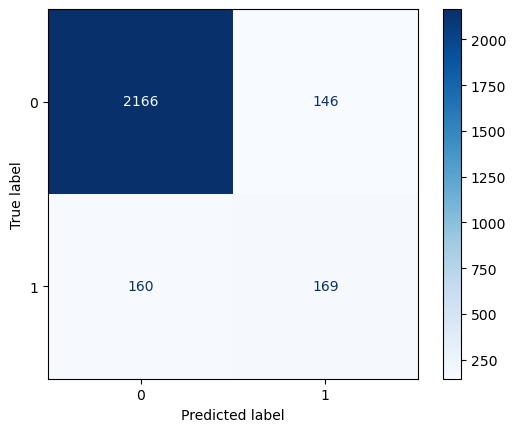

In [23]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### As a result:

* Logistic Regression is the best model for the job.
* Accuracy of the model is 0.884
* Even though accuracy is high, confusion matrix results are not very promising. 160 podiums is missed against 169 correct predicted result.
* Next steps must be adding more features to provide more information that effecting podium finish
* According to result of this notebook, top 5 circuits is shown below. These circuits have most chance to finish in podium when starting in top 3.

| circuitId | grid | start | finish | Predicted | Out of Podium | Podium Chance |
|-----------|------|-------|--------|-----------|---------------|---------------|
| 73        | 1    | 1     | 1      | 1         | 0.396816788   | 0.603183212   |
| 71        | 1    | 1     | 1      | 1         | 0.397187843   | 0.602812157   |
| 70        | 1    | 1     | 1      | 1         | 0.397373416   | 0.602626584   |
| 70        | 1    | 1     | 1      | 1         | 0.397373416   | 0.602626584   |
| 70        | 1    | 1     | 1      | 1         | 0.397373416   | 0.602626584   |
| 70        | 1    | 1     | 1      | 1         | 0.397373416   | 0.602626584   |
| 70        | 1    | 1     | 1      | 1         | 0.397373416   | 0.602626584   |
| 69        | 1    | 1     | 1      | 1         | 0.397559017   | 0.602440983   |
| 69        | 1    | 1     | 1      | 1         | 0.397559017   | 0.602440983   |
| 34        | 1    | 1     | 1      | 1         | 0.404073298   | 0.595926702   |
| 34        | 1    | 1     | 1      | 1         | 0.404073298   | 0.595926702   |

* **Name of the top 5 circuits:**

1. Azerbaijan Grand Prix
2. Russian Grand Prix  
3. Austrian Grand Prix  
4. United States Grand Prix  
5. French Grand Prix 